## Benchmark of mean preserving splines against regular splines

In [ ]:
import pylab as pl
import pandas as pd

from scipy.interpolate import interp1d  # for regular splines interpolation
from mpsplines import MeanPreservingInterpolation as MPI

**Test dataset:** Solar irradiance observations from the BSRN station at Carpentras, France (Access to data via [PANGAEA](https://www.pangaea.de/?q=project%3Alabel%3ABSRN+%2Bevent%3Alabel%3ACAR+-guidelines&mindate=2014-01-01T00%3A00%3A00&maxdate=2018-12-31T23%3A59%3A59))
The data is retrieved at the native 1-min time resolution, from which daily totals, in kWh/m2, are calculated.

In [ ]:
obs_daily = pd.read_csv('carpentras_daily_total_Whm-2.csv', index_col=0, parse_dates=True)

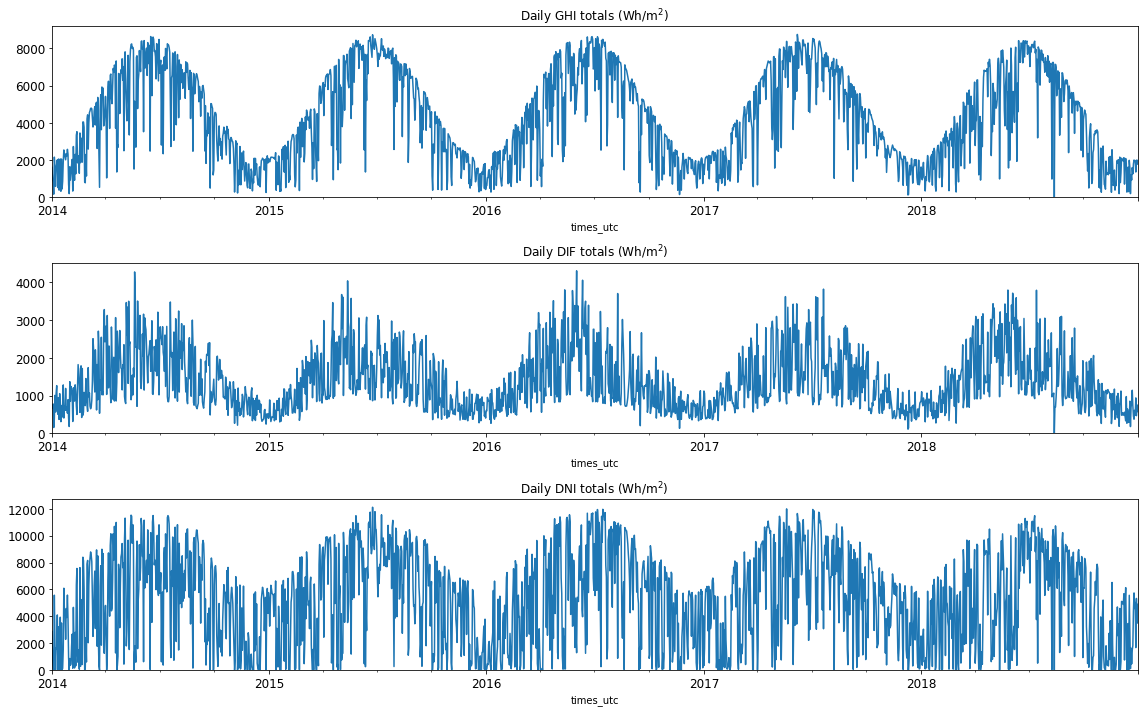

In [ ]:
for n, component in enumerate(obs_daily.columns):
    ax = pl.subplot(3, 1, n+1)
    kwargs = dict(ax=pl.subplot(3, 1, n+1), figsize=(16, 10), ylim=(0, None), fontsize=12)
    obs_daily[component].plot(kind='line', title=f'Daily {component.upper()} totals (Wh/m$^2$)', **kwargs)
pl.tight_layout()

For test purposes, monthly averages of daily totals are computed from the observed daily totals. Then, new daily totals are interpolated from the monthly averages using mean-preserving splines and regular splines.

Afterwards, the interpolated daily totals with each interpolation method are assessed against the original daily totals.

In [ ]:
SPLINES_ORDER = (1, 2, 3)
COMPONENTS = list(obs_daily.columns)

obs_monthly = obs_daily.resample('M').mean()
obs_monthly.index = obs_monthly.index.map(lambda dt: dt.replace(day=15))

def mp_splines(component, **kwargs):
    return MPI(xi=obs_monthly.index, yi=obs_monthly[component], **kwargs)(obs_daily.index)

def regular_splines(component, order, **kwargs):
    kwargs['kind'] = order
    kwargs.setdefault('bounds_error', False)
    kwargs.setdefault('fill_value', 'extrapolate')
    xi = obs_monthly.index.to_numpy().astype('float128')
    x = obs_daily.index.to_numpy().astype('float128')
    return interp1d(xi, obs_monthly[component], **kwargs)(x)

data_daily_interp = pd.DataFrame(
    index=obs_daily.index,
    columns=pd.MultiIndex.from_product(
        [COMPONENTS, ['obs', 'mpi'] + [f'sp{order}' for order in SPLINES_ORDER]],
        names=['component', 'origin']
    )
)

for component in COMPONENTS:
    data_daily_interp[(component, 'obs')] = obs_daily[component]
    data_daily_interp[(component, 'mpi')] = mp_splines(component)
    
    for order in SPLINES_ORDER:
        data_daily_interp[(component, f'sp{order}')] = regular_splines(component, order)

(
    data_daily_interp.set_index(data_daily_interp.index.strftime("%Y-%m")).style
        .format(precision=1)
        .set_caption('Observed and interpolated daily totals (kWh/m$^2$)')
)

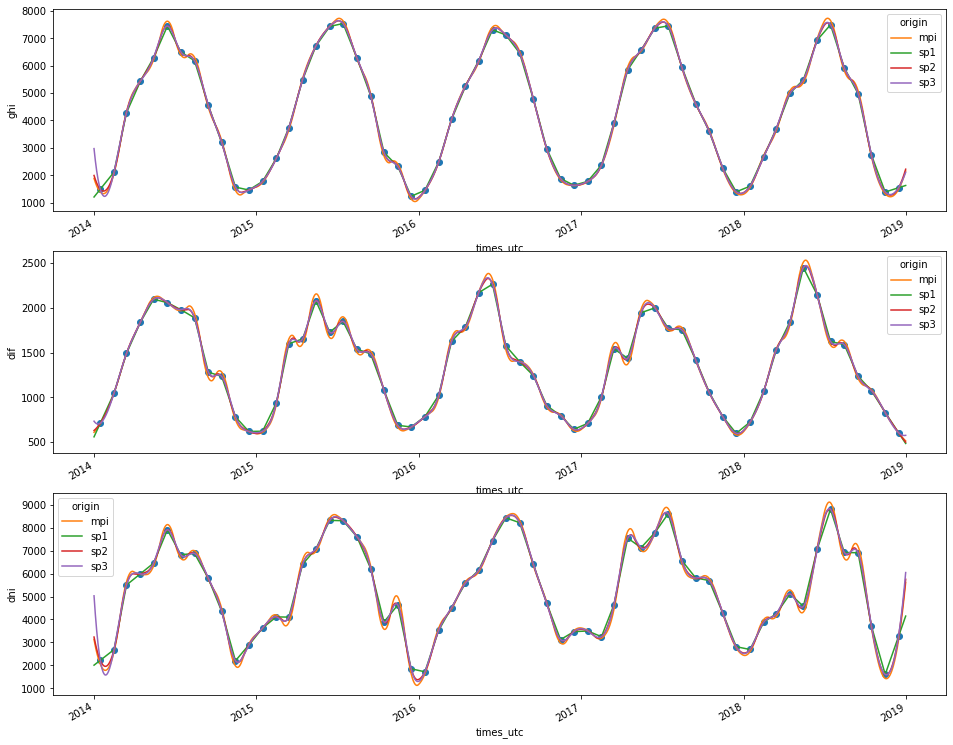

In [ ]:
for n, component in enumerate(COMPONENTS):
    ax = pl.subplot(3, 1, n+1)
    obs_monthly.loc[:, component].plot(kind='line', ls='', marker='o', ylabel=component, figsize=(16, 14), ax=ax)
    data_daily_interp.loc[:, component].drop(columns=['obs']).plot(kind='line', ax=ax)

In [ ]:
monthly_totals = data_daily_interp.groupby(pd.Grouper(freq="MS")).sum() / 1e3  # kWh/m2

interp_values = monthly_totals.drop(columns=[(component, 'obs') for component in COMPONENTS])
residue = pd.DataFrame(index=interp_values.index, columns=interp_values.columns)
for component in COMPONENTS:
    residue[component] = interp_values[component].apply(lambda x: x - monthly_totals[component]['obs'])
(
    residue.set_index(residue.index.strftime("%Y-%m")).style
        .format(precision=4)
        .set_caption('Monthly residues from interpolated totals (kWh/m$^2$)')
)

In [ ]:
metrics = residue.agg(
    [
        lambda x: x.mean(),
        lambda x: x.abs().mean(),
        lambda x: x.pow(2).mean()**0.5,
    ]
)
metrics.index = ['Mean Bias Error', 'Mean Absolute Error', 'Root Mean Square Error']

(
    metrics.style
        .format(precision=3)
        .background_gradient(axis=None)
        .set_caption('Error metrics (kWh/m$^2$)')
)

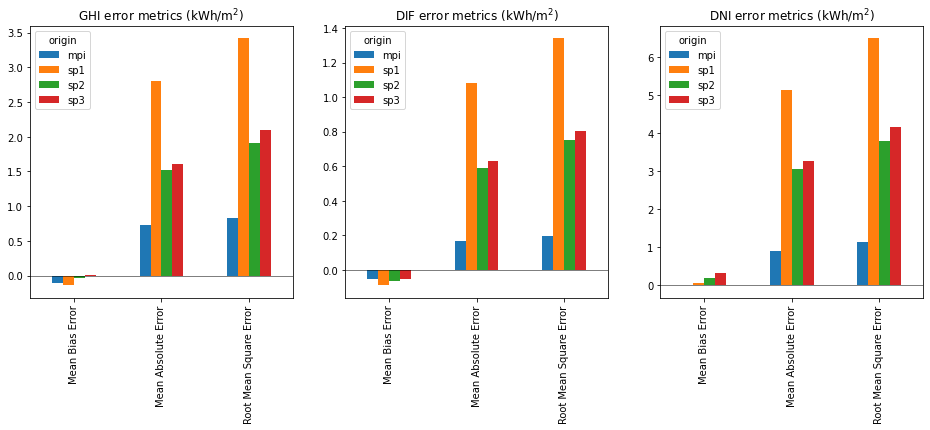

In [ ]:
for n, component in enumerate(COMPONENTS):
    ax = pl.subplot(1, 3, n+1)
    kwargs = dict(kind='bar', ax=ax, figsize=(16, 5))
    metrics[component].plot(title=f'{component.upper()} error metrics (kWh/m$^2$)', **kwargs);
    ax.axhline(color='k', lw=0.5)